In [3]:
import sys
import os
from pathlib import Path
import math
import awkward as ak
import numpy as np
import uproot
import boost_histogram as bh
import hist
from hist import Hist, intervals
import matplotlib.pyplot as plt
from matplotlib import cycler
import mplhep as hep
from coffea import nanoevents, lookup_tools
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.nanoevents.methods import vector, candidate, nanoaod
from coffea.nanoevents.methods.vector import PtEtaPhiELorentzVector
from coffea.lookup_tools import extractor, evaluator
from coffea.analysis_tools import PackedSelection
import dask
from dask import delayed
from dask.distributed import Client
from dask_jobqueue import HTCondorCluster


In [4]:
MAX_WORKERS = 10
CHUNKSIZE = 5000
MAX_CHUNKS = None

In [5]:
@delayed(pure=True)
def get_tree(url):    
    return uproot.open(url)["Events"]

In [6]:
redirector = "/hdfs/store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
redirector17D = "/hdfs/store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"

mt_fileset = {
    "DYJets": [
        redirector+f"/2018/MC/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/231225_151806/0000/NANO_NANO_{i}.root"
        for i in range(1,5)
    ],
    "WJets": [
        redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_{i}.root"
        for i in range(1,5)
    ],
    "TT": [
        redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0000/NANO_NANO_{i}.root"
        for i in range(1,5) #leptonic
    ],  
    "VV": [
        redirector+f"/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_{i}.root"
        for i in range(1,5)
    ],
    "Data": [
        redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_{i}.root"
        for i in range(1,5) #fix get real data
    ]
}
inputs = []
for label in mt_fileset:
    input = [get_tree(url) for url in mt_fileset[label]]
    inputs = np.append(inputs, input)
inputs

array([Delayed('get_tree-64c20bf13a4fff2a71b6b17f1db490bb'),
       Delayed('get_tree-4baea82ccce92e5ad1707867d1f269c7'),
       Delayed('get_tree-cb4bcfda1112f6a5ead79b51b8779e0e'),
       Delayed('get_tree-a63be1fb5d4204c66e981c8203d25652'),
       Delayed('get_tree-899da4bc61fb656c636a2b992e6f983c'),
       Delayed('get_tree-0e191df798c6f2171088f389634ff7c7'),
       Delayed('get_tree-779cf405ba69f78536024985b9f30693'),
       Delayed('get_tree-ce406c5d4d489ef3cb17d18da4461340'),
       Delayed('get_tree-e3e179ea516a48c57644e683d78f6f2d'),
       Delayed('get_tree-aebc8b304f244f1571b6db6756970330'),
       Delayed('get_tree-26711c26121cfbd3d22eb0ffb5924d15'),
       Delayed('get_tree-64f5bb08fd37b5c847d0f1d4df2c09c0'),
       Delayed('get_tree-7914fdb3db66993ff08eccc29a67d43f'),
       Delayed('get_tree-6088fc0d165818d5c5573836802a00b0'),
       Delayed('get_tree-eb14750a4834ae7029bf65e423f0188f'),
       Delayed('get_tree-0c82cf6eb9ab54142fa00e2ae263d694'),
       Delayed('get_tree

In [7]:
nevents, = dask.compute([t.num_entries for t in inputs])
nevents

[7437,
 47677,
 40243,
 36018,
 24857,
 47257,
 47914,
 47892,
 96000,
 92000,
 96000,
 96000,
 2964,
 79845,
 80050,
 79861,
 48000,
 48000,
 3000,
 1000]

In [8]:
def bit_mask(bit):
      mask = 0
      mask += (1 << bit)
      return mask

In [9]:
def weightCalc(name):
      WScaleFactor = 1.21
      TT_FulLep_BR= 0.1061
      TT_SemiLep_BR= 0.4392
      TT_Had_BR= 0.4544

      if "Radion" in name: return 1
      elif "DYJets" in name:
         if "50To100" in name: return 387.130778
         elif "100To250" in name: return 89.395097
         elif "250To400" in name: return 3.435181
         elif "400To650" in name: return 0.464024
         elif "650ToInf" in name: return 0.043602
         elif "100to200" in name: return 160.7
         elif "200to400" in name: return 48.63
         elif "400to600" in name: return 6.993
         elif "600to800" in name: return 1.761
         elif "800to1200" in name: return .8021
         elif "1200to2500" in name: return .1937
         elif "2500toInf" in name: return .003514
      elif "WJets" in name:
         if "100To200" in name: return 1345* WScaleFactor
         elif "200To400" in name: return 359.7* WScaleFactor
         elif "400To600" in name: return 48.91* WScaleFactor
         elif "600To800" in name: return 12.05* WScaleFactor
         elif "800To1200" in name: return 5.501* WScaleFactor
         elif "1200To2500" in name: return 1.329* WScaleFactor
         elif "2500ToInf" in name: return 0.03216* WScaleFactor 
      elif "QCD" in name:
         if "300to500" in name: return 347700
         elif "500to700" in name: return 32100
         elif "700to1000" in name: return 6831
         elif "1000to1500" in name: return 1207
         elif "1500to2000" in name: return 119.9
         elif "2000toInf" in name: return 25.24
      elif "ggH125" in name: return 48.30 * 0.0621
      elif "ggZHLL125" in name: return 0.1223 * 0.062 * 3 * 0.033658
      elif "ggZHNuNu125" in name: return 0.1223 * 0.062 * 0.2000
      elif "ggZHQQ125" in name: return 0.1223 * 0.062 * 0.6991
      elif "JJH0" in name:
         if "OneJet" in name: return 0.1383997884
         elif "TwoJet" in name: return 0.2270577971
         elif "ZeroJet" in name: return 0.3989964912
      elif "qqH125" in name: return 3.770 * 0.0621
      elif "Tbar-tchan" in name: return  26.23
      elif "Tbar-tW" in name: return 35.6
      elif "toptopH125" in name: return 0.5033 * 0.062
      elif "T-tchan.root" in name: return 44.07
      elif "T-tW" in name: return 35.6
      elif "TTT" in name:
         if "2L2Nu" in name: return 831.76 * TT_FulLep_BR
         if "Hadronic" in name: return 831.76 * TT_Had_BR
         if "SemiLeptonic" in name: return 831.76 * TT_SemiLep_BR
      elif "VV2l2nu" in name: return 11.95
      elif "WMinus" in name: return 0.5272 * 0.0621
      elif "WPlus" in name: return 0.8331 * 0.0621
      elif "WZ" in name:
         if "nu2q" in name: return 10.71
         elif "1l3nu" in name: return 3.05
         elif "2l2q" in name: return 5.595
         elif "3l1nu" in name: return 4.708
      elif "ZH125" in name: return 0.7544 * 0.0621
      elif "ZZ2l2q" in name: return 3.22
      elif "ZZ4l" in name: return 1.212
      else: print("Something's Wrong!")
      return 1.01

In [10]:
   with uproot.open("pu_distributions_mc_2018.root") as f1:
      with uproot.open("pu_distributions_data_2018.root") as f2:
         mc = f1["pileup"].values()
         data = f2["pileup"].values()
         HistoPUMC = np.divide(mc, ak.sum(mc))
         HistoPUData = np.divide(data, ak.sum(data))
         PUWeight = np.divide(HistoPUData, HistoPUMC)

/tmp/ipykernel_1060304/1460999151.py:7: RuntimeWarning: divide by zero encountered in divide
  PUWeight = np.divide(HistoPUData, HistoPUMC)


In [22]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        ak.behavior.update(nanoaod.behavior)
        self._accumulator = {}
    
    @property
    def accumulator(self,events):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata["dataset"]

        ax = hist.axis.Regular(30, 0, 150, flow=False, name="mass", label=dataset)
        
        
        output = {}
        output[dataset] =  {
            "mass": Hist(ax),
            "mass_w": Hist(ax),
            "ss_mass": Hist(ax),
            "ss_mass_w": Hist(ax),
            "EventCount": processor.value_accumulator(int)
            }
        
        eventCount = len(events)
        name = str(events.metadata["filename"])
        XSection = weightCalc(name)
        print("Start: ", ak.count(events.Muon.pt), " ", str(dataset))
        electron = events.Electron
        ele_cut = (electron.pt >= 15) & (np.abs(electron.eta) <= 2.5)
        lowMVAele = electron[(np.abs(electron.eta) <= 0.8) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.83)
        midMVAele = electron[(np.abs(electron.eta) > 0.8) & (np.abs(electron.eta) <= 1.5) & (electron.mvaIso_WPL) & ele_cut] #electron.mvaFall17V2Iso > -0.77
        highMVAele = electron[(np.abs(electron.eta) >= 1.5) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.69)
        events = events[(ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0)]
        print("Extra Ele Veto: ", ak.count(events.Muon.pt))
        #Extra muon veto
        muon = events.Muon
        muon = muon[ak.num(muon) > 1]
        badMuon = muon[(np.abs(muon.pfRelIso04_all) > 0.3) & (muon[:,1].pt > 10) & (muon.tightId)] #tightId instead of bitwise thing
        events = events[(ak.num(muon) > 0) & (ak.num(badMuon) == 0)]
        print("Extra Mu Veto: ", ak.count(events.Muon.pt))

        #BJets
        jets = events.Jet
        goodJets= jets[(jets.jetId > 0.5) & (jets.pt > 30) & (np.abs(jets.eta) < 3.0)]
        HT = ak.sum(goodJets.pt, axis=-1)

        #BJet Veto 
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! change btagdeepflavb for each year https://btv-wiki.docs.cern.ch/ScaleFactors/UL2018/
        bJets = jets[(jets.btagDeepFlavB > .7100) & (jets.jetId > .5) & (jets.pt > 30) & (np.abs(jets.eta) < 2.4)]
        events = events[(ak.num(jets) > 0) & (HT > 200) & (ak.num(bJets) == 0)]
        print("BJet Veto: ", ak.count(events.Muon.pt))
        mtEvents = events[ak.all((ak.num(events.Muon) > 0) & (ak.num(events.boostedTau) > 0), axis = -1)]
        muonC = events.Muon
        tauC = events.boostedTau
        metC = events.MET
        HLT = mtEvents.HLT
        
        muon = ak.zip( 
    	{
		"pt": muonC.pt,
        "eta": muonC.eta,
		"phi": muonC.phi,
		"mass": muonC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
    	)
        
        tau = ak.zip( 
		{
		"pt": tauC.pt,
        "eta": tauC.eta,
        "phi": tauC.phi,
		"mass": tauC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
    	behavior=vector.behavior,
    	)

        #Split into pairs
        pairs = ak.cartesian({'tau': tau, 'muon': muon}, nested=False)
        pairsC = ak.cartesian({'tau': tauC, 'muon': muonC}, nested=False)
        metPairs = ak.cartesian({'met': metC, 'muon': pairsC['muon']}, nested=False)
        PUPairs = ak.cartesian({'PU': np.rint(events.Pileup.nTrueInt), 'muon': pairsC['muon']}, nested=False)
        print("Pairs: ", ak.count(pairsC['muon'].pt), " Vector: ", ak.count(pairs['muon'].pt))
        #Delta r cut
        dr = pairs['tau'].delta_r(pairs['muon'])
        #ID Cut
        MuID = (pairsC['muon'].tightId) & (np.abs(pairsC['muon'].dz) < 0.2)  # & (np.abs(pairsC['muon'].dxy) < 0.045)
        #Apply everything at once
        print(pairsC['tau'].idDecayModeOldDMs)
        muTau_mask27 = ((np.abs(pairs['muon'].eta) < 2.4)
                  & (MuID)
                  & (pairs['muon'].pt >= 27)
                  & (pairs['muon'].pt < 52)
                  & (pairsC['muon'].pfRelIso04_all <= .3)
                  & (metPairs['met'].pt > 30)
                  & (pairs['tau'].pt > 30)
                  & (HLT.Mu27)
                  & (np.absolute(pairs['tau'].eta) < 2.3)
                  & (pairsC['tau'].idAntiMu > 0)
                  & (pairsC['tau'].idDecayModeOldDMs)
                  & (dr > .1) 
                  & (dr < .8))
        muTau_mask50 = ((np.abs(pairs['muon'].eta) < 2.4)
                  & (MuID)
                  & (pairs['muon'].pt >= 52)
                  & (HLT.Mu50)
                  & (pairs['tau'].pt > 30)
                  & (np.absolute(pairs['tau'].eta) < 2.3)
                  & (pairsC['tau'].idAntiMu > 0)
                  & (pairsC['tau'].idDecayModeOldDMs)
                  & (dr > .1) 
                  & (dr < .8))
         #If everything cut return 0 (to avoid pointer errors)
        if not ak.any(muTau_mask27) and not ak.any(muTau_mask50):
            print("0")
            output[dataset]["EventCount"] += eventCount
            return output
            
        pairs = pairs[(muTau_mask27) | (muTau_mask50)]
        pairsC = pairsC[(muTau_mask27) | (muTau_mask50)]
        metPairs = metPairs[(muTau_mask27) | (muTau_mask50)]
        PUPairs = PUPairs[(muTau_mask27) | (muTau_mask50)]
        print("Postcut: Pairs: ", ak.count(pairsC['muon'].pt), " Vector: ", ak.count(pairs['muon'].pt))
        
        #Separate based on charge
        OS_pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        SS_pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge != 0]
        OS_pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        SS_pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge != 0]
        #Separate based on trigger again
        OS_50 = OS_pairs[OS_pairs['muon'].pt >= 52]
        OS_27 = OS_pairs[OS_pairs['muon'].pt < 52]
        SS_50 = SS_pairs[SS_pairs['muon'].pt >= 52]
        SS_27 = SS_pairs[SS_pairs['muon'].pt < 52]

        OS_50C = OS_pairsC[OS_pairs['muon'].pt >= 52]
        OS_27C = OS_pairsC[OS_pairs['muon'].pt < 52]
        SS_50C = SS_pairsC[SS_pairs['muon'].pt >= 52]
        SS_27C = SS_pairsC[SS_pairs['muon'].pt < 52]


        #If everything cut return 0 (to avoid pointer errors)
        if ak.sum(OS_pairs['tau'].pt) == 0 and ak.sum(SS_pairs['tau'].pt) == 0:

            output[dataset]["EventCount"] += eventCount
            return output
            
            #return {
            #    output[dataset]: {
            #    "mass": np.zeros(0),
            #    "mass_w": np.zeros(0),
            #    "ss_mass": np.zeros(0),
            #    "ss_mass_w": np.zeros(0),
            #    "Mu50IsoCorr": np.zeros(0),
            #    "Mu50IDCorr": np.zeros(0),
            #    "Mu50TrgCorr": np.zeros(0),
            #    "PUCorrection50": np.zeros(0),
            #    "Mu27IsoCorr": np.zeros(0),
            #    "Mu27IDCorr": np.zeros(0),
            #    "Mu27TrgCorr": np.zeros(0),
            #    "PUCorrection27": np.zeros(0),
            #    "pTCorrection50": np.zeros(0),
            #    "pTCorrection27": np.zeros(0),
               # }
           # }
        
        #Create vectors
        #OS
        muVec50 = OS_50['muon']
        tauVec50 = OS_50['tau']
        muVec27 = OS_27['muon']
        tauVec27 = OS_27['tau']
        
        OSmet50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSmet50 = OSmet50[(OS_pairs['muon'].pt >= 52)]
        OSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSmet27 = OSmet27[(OS_pairs['muon'].pt < 52)]
        SSmet50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSmet50 = SSmet50[(SS_pairs['muon'].pt >= 52)]
        SSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSmet27 = SSmet27[(SS_pairs['muon'].pt < 52)]

        OSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSPU50 = OSPU50[(OS_pairs['muon'].pt >= 52)]
        OSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSPU27 = PUPairs[(OS_pairs['muon'].pt < 52)]
        SSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSPU50 = SSPU50[(SS_pairs['muon'].pt >= 52)]
        SSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSPU27 = SSPU27[(SS_pairs['muon'].pt < 52)]

        #TMass Cut
        tmass50 = np.sqrt(np.square(OS_50['muon'].pt + OSmet50['met'].pt) - np.square(OS_50['muon'].px + OSmet50['met'].pt * np.cos(OSmet50['met'].phi)) - np.square(OS_50['muon'].py + OSmet50['met'].pt * np.sin(OSmet50['met'].phi)))
        tmass27 = np.sqrt(np.square(OS_27['muon'].pt + OSmet27['met'].pt) - np.square(OS_27['muon'].px + OSmet27['met'].pt * np.cos(OSmet27['met'].phi)) - np.square(OS_27['muon'].py + OSmet27['met'].pt * np.sin(OSmet27['met'].phi)))
        print(tmass27 < 80)
        print(OS_27)
        
        OS_50 = OS_50[tmass50 < 80]
        OS_27 = OS_27[tmass27 < 80]
        OS_50C = OS_50C[tmass50 < 80]
        OS_27C = OS_27C[tmass27 < 80]

        OSmet50 = OSmet50[tmass50 < 80]
        OSmet27 = OSmet27[tmass27 < 80]
        OSPU50 = OSPU50[tmass50 < 80]
        OSPU27 = OSPU27[tmass27 < 80]

        
        tmass50_SS = np.sqrt(np.square(SS_50['muon'].pt + SSmet50['met'].pt) - np.square(SS_50['muon'].px + SSmet50['met'].pt * np.cos(SSmet50['met'].phi)) - np.square(SS_50['muon'].py + SSmet50['met'].pt * np.sin(SSmet50['met'].phi)))
        tmass27_SS = np.sqrt(np.square(SS_27['muon'].pt + SSmet27['met'].pt) - np.square(SS_27['muon'].px + SSmet27['met'].pt * np.cos(SSmet27['met'].phi)) - np.square(SS_27['muon'].py + SSmet27['met'].pt * np.sin(SSmet27['met'].phi)))

        SS_50 = SS_50[tmass50_SS < 80]
        SS_27 = SS_27[tmass27_SS < 80]
        SS_50C = SS_50C[tmass50_SS < 80]
        SS_27C = SS_27C[tmass27_SS < 80]

        SSmet50 = SSmet50[tmass50_SS < 80]
        SSmet27 = SSmet27[tmass27_SS < 80]
        SSPU50 = SSPU50[tmass50_SS < 80]
        SSPU27 = SSPU27[tmass27_SS < 80]

        
        #MET Vector
        MetVec27 =  ak.zip(
        {
        "pt": OSmet27['met'].pt,
        "eta": 0,
        "phi": OSmet27['met'].phi,
        "mass": 0,
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        MetVec50 =  ak.zip(
        {
         "pt": OSmet50['met'].pt,
         "eta": 0,
         "phi": OSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )   
        MetVec27_SS =  ak.zip(
        {
         "pt": SSmet27['met'].pt,
         "eta": 0,
         "phi": SSmet27['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )  
        MetVec50_SS =  ak.zip(
        {
         "pt": SSmet50['met'].pt,
         "eta": 0,
         "phi": SSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 

        #Make Z Vector
         #OS
        ZVec50 = OS_50['tau'].add(OS_50['muon'])
        ZVec27 = OS_27['tau'].add(OS_27['muon'])
        #Make Higgs Vector
        Higgs50 = ZVec50.add(MetVec50)
        Higgs27 = ZVec27.add(MetVec27)


        #SS
        ZVec50_SS = SS_50['tau'].add(SS_50['muon'])
        ZVec27_SS = SS_27['tau'].add(SS_27['muon'])
        #Make Higgs Vector
        Higgs50_SS = ZVec50_SS.add(MetVec50_SS)
        Higgs27_SS = ZVec27_SS.add(MetVec27_SS)


        #Final ZVec Cuts
        ZVec50 = ZVec50[(ZVec50.pt > 200) & (Higgs50.pt > 250)]
        ZVec27 = ZVec27[(ZVec27.pt > 200) & (Higgs27.pt > 250)]
        ZVec50_SS = ZVec50_SS[(ZVec50_SS.pt > 200) & (Higgs50_SS.pt > 250)]
        ZVec27_SS = ZVec27_SS[(ZVec27_SS.pt > 200) & (Higgs27_SS.pt > 250)]


        #Add weight sets
        ext = extractor()
        ext.add_weight_sets(["IDCorr NUM_LooseID_DEN_genTracks_pt_abseta ./RunBCDEF_SF_ID.root", "Trg50Corr Mu50_OR_TkMu50_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "Trg27Corr IsoMu24_OR_IsoTkMu24_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "IsoCorr NUM_LooseRelIso_DEN_LooseID_pt_abseta ./RunBCDEF_SF_ISO.root", "pTCorr Ratio2D ./zmm_2d_2018.root"])
        ext.finalize()
        evaluator = ext.make_evaluator()


        #Get Shape
        shape = np.shape(np.append(ak.flatten(ZVec27.mass, axis=1), ak.flatten(ZVec50.mass, axis=1)))
        SS_shape = np.shape(np.append(ak.flatten(ZVec27_SS.mass, axis=1), ak.flatten(ZVec50_SS.mass, axis=1)))

        Mu50IsoCorr, Mu50IDCorr, Mu50TrgCorr, PUCorrection50, pTCorrection50 = [], [], [], [], []
        Mu27IsoCorr, Mu27IDCorr, Mu27TrgCorr, PUCorrection27, pTCorrection27 = [], [], [], [], []


        if XSection != 1:
            #Shortcut names to make things easier
            ZVec50pt = ak.flatten(ZVec50.pt, axis=-1)
            ZVec50eta = ak.flatten(ZVec50.eta, axis=-1)
            ZVec50_SSpt = ak.flatten(ZVec50_SS.pt, axis=-1)
            ZVec50_SSeta = ak.flatten(ZVec50_SS.eta, axis=-1)
            ZVec27pt = ak.flatten(ZVec27.pt, axis=-1)
            ZVec27eta = ak.flatten(ZVec27.eta, axis=-1)
            ZVec27_SSpt = ak.flatten(ZVec27_SS.pt, axis=-1)
            ZVec27_SSeta = ak.flatten(ZVec27_SS.eta, axis=-1)

            #OS
            Mu50IsoCorr = evaluator["IsoCorr"](ZVec50pt, ZVec50eta)   #Iso
            Mu50TrgCorr = evaluator["Trg50Corr"](ZVec50pt, ZVec50eta) #Trigger
            Mu50IDCorr = evaluator["IDCorr"](ZVec50pt, ZVec50eta) #ID
            #Mu27IsoCorr = evaluator["IsoCorr"](ZVec27pt, ZVec27eta) 
            Mu27TrgCorr = evaluator["Trg27Corr"](ZVec27pt, ZVec27eta) 
            Mu27IDCorr = evaluator["IDCorr"](ZVec27pt, ZVec27eta) 

            
            
            puTrue50 = np.array(ak.flatten(OSPU50['PU'][ZVec50.pt > 200], axis=-1), dtype=np.int8) #Pileup
            puTrue27 = np.array(ak.flatten(OSPU27['PU'][ZVec27.pt > 200], axis=-1), dtype=np.int8)
            PUCorrection50 = PUWeight[puTrue50]
            PUCorrection27 = PUWeight[puTrue27]
            

            Lep50Corr = Mu50IsoCorr * Mu50TrgCorr * Mu50IDCorr  * PUCorrection50 #Combine
            Lep27Corr = Mu27IsoCorr * Mu27TrgCorr * Mu27IDCorr  * PUCorrection27

            #SS
            Mu50IsoCorr_SS = evaluator["IsoCorr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50TrgCorr_SS = evaluator["Trg50Corr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50IDCorr_SS = evaluator["IDCorr"](ZVec50_SSpt, ZVec50_SSeta)  
            Mu27IsoCorr_SS = evaluator["IsoCorr"](ZVec27_SSpt, ZVec27_SSeta) 
            Mu27TrgCorr_SS = evaluator["Trg27Corr"](ZVec27_SSpt, ZVec27_SSeta)  
            Mu27IDCorr_SS = evaluator["IDCorr"](ZVec27_SSpt, ZVec27_SSeta) 

            puTrue50_SS = np.array(ak.flatten(SSPU50['PU'][ZVec50_SS.pt > 200], axis=-1), dtype=np.int8)
            puTrue27_SS = np.array(ak.flatten(SSPU27['PU'][ZVec27_SS.pt > 200], axis=-1), dtype=np.int8)
            PUCorrection50_SS = PUWeight[puTrue50_SS]
            PUCorrection27_SS = PUWeight[puTrue27_SS]

            Lep50Corr_SS = Mu50IsoCorr_SS * Mu50TrgCorr_SS * Mu50IDCorr_SS * PUCorrection50_SS
            Lep27Corr_SS = Mu27IsoCorr_SS * Mu27TrgCorr_SS * Mu27IDCorr_SS * PUCorrection27_SS

            #Luminosity (2018)
            luminosity = 59830.
            lumiWeight = (XSection * luminosity) / eventCount
            
            LepCorrection = np.append(ak.flatten(Lep27Corr, axis=-1), ak.flatten(Lep50Corr, axis=-1), axis=-1) 
            #OS
            if ("DYJets" in name): 
                #Zpt correction
                pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                Lep27Corr = Lep27Corr * pTCorrection27
                Lep50Corr = Lep50Corr * pTCorrection50
                LepCorrection = np.append(ak.flatten(Lep27Corr, axis=-1), ak.flatten(Lep50Corr, axis=-1), axis=-1)
            
            #SS
            SS_LepCorrection = np.append(ak.flatten(Lep27Corr_SS, axis=-1), ak.flatten(Lep50Corr_SS, axis=-1), axis=-1) 

            #Get shape
            mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
            mass_w = np.multiply(mass_w, ak.flatten(LepCorrection, axis=-1))
            SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
            SS_mass_w = np.multiply(SS_mass_w, ak.flatten(SS_LepCorrection, axis=-1))
        else:
            mass_w = np.full(shape=shape, fill_value=1, dtype=np.double)
            SS_mass_w = np.full(shape=SS_shape, fill_value=1, dtype=np.double) 

        vismass = np.append(ak.flatten(ZVec27.mass, axis=-1), ak.flatten(ZVec50.mass, axis=-1), axis=-1)
        ss_vismass = np.append(ak.flatten(ZVec27_SS.mass, axis=-1), ak.flatten(ZVec50_SS.mass, axis=-1), axis=-1)
        
        output[dataset]["mass"].fill(mass=vismass, weight=mass_w)
        #output[dataset]["mass_w"].fill(mass=mass_w)
        output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=SS_mass_w)
        #output[dataset]["ss_mass_w"].fill(mass=SS_mass_w)
        output[dataset]["EventCount"] += eventCount

        return output

    def postprocess(self, accumulator):
        return accumulator
    

In [23]:
local_executor = processor.IterativeExecutor(status=True)

#Create the runner
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=local_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 5000 and maxchunks None


In [24]:
print("Calling runner")
mt_results_local = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Output()

Calling runner


Start:  1548   Data

Extra Ele Veto:  1109

Extra Mu Veto:  266

BJet Veto:  38

Pairs:  163  Vector:  163

[[False, True], [False, False, True], ... True, True, True, True, False, False], []]

0

Start:  4445   Data

Extra Ele Veto:  3145

Extra Mu Veto:  616

BJet Veto:  149

Pairs:  623  Vector:  623

[[], [True, True], [], [True, ... True, True, True, True, True, True, True, True]]

0

Start:  7103   Data

Extra Ele Veto:  4964

Extra Mu Veto:  966

BJet Veto:  187

Pairs:  722  Vector:  722

[[], [True, True, False, True], [True, ... False, True, True, True, False], [], []]

0

Start:  7044   Data

Extra Ele Veto:  4857

Extra Mu Veto:  916

BJet Veto:  168

Pairs:  711  Vector:  711

[[True, True, True, True, False, False], ... False, True, True, True, True, True]]

Postcut: Pairs:  15  Vector:  15

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7428   Data

Extra Ele Veto:  5109

Extra Mu Veto:  1031

BJet Veto:  222

Pairs:  895  Vector:  895

[[True, False, True], [], [True, False, ... True, True, True, True, True, True], []]

0

Start:  7249   Data

Extra Ele Veto:  5126

Extra Mu Veto:  1038

BJet Veto:  185

Pairs:  758  Vector:  758

[[], [], [True, True, True], ... True, True, True, True, False, False, False], []]

0

Start:  7085   Data

Extra Ele Veto:  4753

Extra Mu Veto:  893

BJet Veto:  176

Pairs:  751  Vector:  751

[[False, False, False, False, True, True, ... True, True, True, True, True, True]]

Postcut: Pairs:  12  Vector:  12

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7276   Data

Extra Ele Veto:  4988

Extra Mu Veto:  950

BJet Veto:  196

Pairs:  728  Vector:  728

[[True, True, True, True, True, True, True, ... True], [True, True, True, True]]

Postcut: Pairs:  15  Vector:  15

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7457   Data

Extra Ele Veto:  5279

Extra Mu Veto:  1045

BJet Veto:  203

Pairs:  784  Vector:  784

[[], [], [], [True, True, True, ... True, True, True, True, True], [True, True]]

0

Start:  7263   Data

Extra Ele Veto:  5092

Extra Mu Veto:  1023

BJet Veto:  183

Pairs:  746  Vector:  746

[[False, False, False, False, False, True, ... False, False, True, True, True, True]]

Postcut: Pairs:  22  Vector:  22

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7104   Data

Extra Ele Veto:  4924

Extra Mu Veto:  978

BJet Veto:  164

Pairs:  651  Vector:  651

[[], [True, True, True, True], [True, ... True, True, True], [True, False, False]]

0

Start:  7229   Data

Extra Ele Veto:  4917

Extra Mu Veto:  964

BJet Veto:  195

Pairs:  743  Vector:  743

[[False, True, True], [True, True, ... False, True, True, True, True, True, True]]

0

Start:  7213   Data

Extra Ele Veto:  5067

Extra Mu Veto:  972

BJet Veto:  188

Pairs:  767  Vector:  767

[[], [], [True, True, True, True, ... True, True, True, False, False, False, False]]

0

Start:  7381   Data

Extra Ele Veto:  5054

Extra Mu Veto:  966

BJet Veto:  191

Pairs:  802  Vector:  802

[[True, True, True, True, True, True, True, ... False, True, True, True], [True]]

Postcut: Pairs:  20  Vector:  20

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7298   Data

Extra Ele Veto:  4975

Extra Mu Veto:  985

BJet Veto:  213

Pairs:  884  Vector:  884

[[True, True, True, True, True, True, True, True, ... [], [True, True, False, True]]

Postcut: Pairs:  17  Vector:  17

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7353   Data

Extra Ele Veto:  5137

Extra Mu Veto:  1087

BJet Veto:  204

Pairs:  717  Vector:  717

[[False, True, True], [True, True, False, ... False, False], [True, False, True]]

Postcut: Pairs:  13  Vector:  13

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7233   Data

Extra Ele Veto:  5052

Extra Mu Veto:  975

BJet Veto:  199

Pairs:  777  Vector:  777

[[], [True, False], [False, False, False, ... True, True, True, True, True], [], []]

0

Start:  7016   Data

Extra Ele Veto:  4785

Extra Mu Veto:  968

BJet Veto:  174

Pairs:  695  Vector:  695

[[False, True, True, True], [], ... True, True, False, False, False, False, False]]

Postcut: Pairs:  16  Vector:  16

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [True], [], [], []]

[[], [], [], [], [], [], [], ... phi: -0.0213, mass: 0.106}}], [], [], []]

Start:  7169   Data

Extra Ele Veto:  4850

Extra Mu Veto:  873

BJet Veto:  220

Pairs:  844  Vector:  844

[[True, True, True, True, False, False, False, ... [], [True, False, True, True]]

0

Start:  7085   Data

Extra Ele Veto:  5058

Extra Mu Veto:  979

BJet Veto:  190

Pairs:  748  Vector:  748

[[], [], [True, True, False, False, ... True, True, True, True, True, True], []]

0

Start:  7068   Data

Extra Ele Veto:  4880

Extra Mu Veto:  912

BJet Veto:  224

Pairs:  826  Vector:  826

[[True, True, False, False, True, True, False, ... [False, False, True, True, False]]

Postcut: Pairs:  20  Vector:  20

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  7161   Data

Extra Ele Veto:  4976

Extra Mu Veto:  975

BJet Veto:  199

Pairs:  769  Vector:  769

[[False, True, True], [True, True], [True, ... True, True], [True, True, True], []]

0

Start:  1683   VV

Extra Ele Veto:  1602

Extra Mu Veto:  45

BJet Veto:  19

Pairs:  34  Vector:  34

[[True], [True, True, True, True, True, True, True, ... [True], [], [True, True], []]

0

Start:  1645   VV

Extra Ele Veto:  1560

Extra Mu Veto:  35

BJet Veto:  8

Pairs:  12  Vector:  12

[[], [False, True], [], [], [False], [False, ... [], [True, True], [], [True], []]

0

Start:  1631   VV

Extra Ele Veto:  1547

Extra Mu Veto:  29

BJet Veto:  4

Pairs:  7  Vector:  7

[[True], [False], [], [False, True], [], [], [], [], [False, True, True], [], []]

0

Start:  1706   VV

Extra Ele Veto:  1603

Extra Mu Veto:  45

BJet Veto:  15

Pairs:  33  Vector:  33

[[True, True, False, True], [], [False, True, ... [], [False], [False, True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [True]]

[[], [], [], [], [], [], ... muon: {pt: 31.9, eta: -0.37, phi: 1.14, mass: 0.106}}]]

Start:  1623   VV

Extra Ele Veto:  1534

Extra Mu Veto:  32

BJet Veto:  7

Pairs:  9  Vector:  9

[[], [True, True], [], [], [], [], ... [True, False], [], [True, False], [], []]

0

Start:  1667   VV

Extra Ele Veto:  1568

Extra Mu Veto:  43

BJet Veto:  14

Pairs:  16  Vector:  16

[[], [], [False, True, True], [True], [], ... [], [True, False], [], [True], []]

0

Start:  1598   VV

Extra Ele Veto:  1525

Extra Mu Veto:  38

BJet Veto:  16

Pairs:  31  Vector:  31

[[], [], [True, False], [], [True, ... [False, True, True], [True, True], []]

0

Start:  1711   VV

Extra Ele Veto:  1620

Extra Mu Veto:  52

BJet Veto:  22

Pairs:  51  Vector:  51

[[False], [], [False], [], [], [True, ... True, True], [], [True], [], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  1618   VV

Extra Ele Veto:  1538

Extra Mu Veto:  31

BJet Veto:  13

Pairs:  23  Vector:  23

[[True, True, True], [], [], [], [], [], [], ... [], [], [], [], [], [], [True], []]

0

Start:  1654   VV

Extra Ele Veto:  1577

Extra Mu Veto:  43

BJet Veto:  15

Pairs:  36  Vector:  36

[[False, True, True, True, True], [], [True, ... False, False, False], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  1610   VV

Extra Ele Veto:  1524

Extra Mu Veto:  39

BJet Veto:  16

Pairs:  23  Vector:  23

[[False, True], [], [False, False], [], ... True], [True], [], [True, True, True]]

0

Start:  1667   VV

Extra Ele Veto:  1558

Extra Mu Veto:  36

BJet Veto:  12

Pairs:  20  Vector:  20

[[True, True], [True], [True], [], [], ... True], [], [], [], [True], [True]]

0

Start:  1655   VV

Extra Ele Veto:  1568

Extra Mu Veto:  31

BJet Veto:  9

Pairs:  20  Vector:  20

[[], [], [True], [], [True, False], [], ... [True], [], [], [True, True], [], []]

0

Start:  1623   VV

Extra Ele Veto:  1538

Extra Mu Veto:  36

BJet Veto:  9

Pairs:  12  Vector:  12

[[True, True], [], [True, True], [], [], ... [False, False], [True], [], [], []]

0

Start:  1613   VV

Extra Ele Veto:  1517

Extra Mu Veto:  37

BJet Veto:  13

Pairs:  31  Vector:  31

[[], [], [], [], [False], ... True, True], [], [True, True, True, False, False]]

0

Start:  1656   VV

Extra Ele Veto:  1568

Extra Mu Veto:  40

BJet Veto:  11

Pairs:  16  Vector:  16

[[True, True], [False, False], [], [True, False, ... False], [], [], [], [], []]

0

Start:  1579   VV

Extra Ele Veto:  1489

Extra Mu Veto:  31

BJet Veto:  16

Pairs:  24  Vector:  24

[[True, True], [], [], [True, True], [], ... [], [True], [], [True, True, True], []]

0

Start:  1641   VV

Extra Ele Veto:  1556

Extra Mu Veto:  47

BJet Veto:  29

Pairs:  58  Vector:  58

[[False], [False, True], [False, False], ... [True, True], [True, True, False], []]

0

Start:  1599   VV

Extra Ele Veto:  1498

Extra Mu Veto:  34

BJet Veto:  10

Pairs:  22  Vector:  22

[[], [True, True], [], [True, True], ... True, True, True, True], [], [], [], []]

0

Start:  1660   VV

Extra Ele Veto:  1545

Extra Mu Veto:  39

BJet Veto:  15

Pairs:  31  Vector:  31

[[], [], [True, True], [], [], [], ... True], [], [True, True], [False, False], []]

0

Start:  1617   VV

Extra Ele Veto:  1518

Extra Mu Veto:  37

BJet Veto:  13

Pairs:  19  Vector:  19

[[], [True], [True, False], [], [], [], ... True], [], [], [], [], [False, False]]

0

Start:  1679   VV

Extra Ele Veto:  1568

Extra Mu Veto:  43

BJet Veto:  12

Pairs:  26  Vector:  26

[[], [True, False], [], [True, True], [], ... False], [], [], [], [], [True, True]]

0

Start:  1675   VV

Extra Ele Veto:  1574

Extra Mu Veto:  44

BJet Veto:  13

Pairs:  20  Vector:  20

[[], [], [True, True], [True], [False, False, ... True], [True], [], [], [], []]

0

Start:  1709   VV

Extra Ele Veto:  1614

Extra Mu Veto:  39

BJet Veto:  9

Pairs:  11  Vector:  11

[[True], [], [False], [], [], ... [False, False], [], [True, False, True], []]

0

Start:  1703   VV

Extra Ele Veto:  1603

Extra Mu Veto:  44

BJet Veto:  20

Pairs:  44  Vector:  44

[[False, True], [True], [], [], ... [True, False, False, True], [False, False]]

0

Start:  1648   VV

Extra Ele Veto:  1562

Extra Mu Veto:  48

BJet Veto:  20

Pairs:  49  Vector:  49

[[], [True, True, False], [False, True, ... [True, True], [True, False, False]]

0

Start:  1635   VV

Extra Ele Veto:  1555

Extra Mu Veto:  39

BJet Veto:  13

Pairs:  25  Vector:  25

[[False, False], [], [True, True], [], ... False, True], [], [], [True, True], []]

0

Start:  1613   VV

Extra Ele Veto:  1537

Extra Mu Veto:  42

BJet Veto:  12

Pairs:  21  Vector:  21

[[], [], [], [], [True, True, False, False, ... True], [True], [], [False], [False]]

0

Start:  1632   VV

Extra Ele Veto:  1544

Extra Mu Veto:  51

BJet Veto:  18

Pairs:  22  Vector:  22

[[], [], [True, True, True, True], [], ... True], [False, True, True], [], [], []]

0

Start:  1588   VV

Extra Ele Veto:  1501

Extra Mu Veto:  32

BJet Veto:  13

Pairs:  24  Vector:  24

[[True], [], [True], [], [], [], ... False], [True, False], [], [False, True, True]]

0

Start:  1665   VV

Extra Ele Veto:  1587

Extra Mu Veto:  48

BJet Veto:  18

Pairs:  41  Vector:  41

[[], [], [], [True, False], [True], ... [False, False], [], [False, True, False]]

0

Start:  1690   VV

Extra Ele Veto:  1593

Extra Mu Veto:  45

BJet Veto:  15

Pairs:  35  Vector:  35

[[False, True], [], [], [], [], ... False, False, False, False], [False], [True]]

0

Start:  1618   VV

Extra Ele Veto:  1543

Extra Mu Veto:  37

BJet Veto:  12

Pairs:  27  Vector:  27

[[], [], [], [True, False, True, True, ... True], [False, False, True, True], []]

0

Start:  1665   VV

Extra Ele Veto:  1568

Extra Mu Veto:  40

BJet Veto:  15

Pairs:  26  Vector:  26

[[True, True, True], [True, True, True, True, ... True, True], [True, True], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  1666   VV

Extra Ele Veto:  1554

Extra Mu Veto:  41

BJet Veto:  13

Pairs:  19  Vector:  19

[[True], [], [True], [True, True], [False, ... [], [True, False], [], [False], []]

0

Start:  1599   VV

Extra Ele Veto:  1516

Extra Mu Veto:  33

BJet Veto:  11

Pairs:  20  Vector:  20

[[], [True, True], [], [], [], [True, False], ... [], [], [], [], [], [True], []]

0

Start:  1607   VV

Extra Ele Veto:  1520

Extra Mu Veto:  28

BJet Veto:  12

Pairs:  21  Vector:  21

[[True, True, False], [], [], [], [], ... [True, True], [True, True], [False, True]]

0

Start:  1698   VV

Extra Ele Veto:  1597

Extra Mu Veto:  30

BJet Veto:  10

Pairs:  13  Vector:  13

[[], [True, False, False], [], [], [], [], ... False, False], [], [], [], [], [], []]

0

Start:  1676   VV

Extra Ele Veto:  1574

Extra Mu Veto:  33

BJet Veto:  15

Pairs:  33  Vector:  33

[[False, False], [], [], [], [], [], ... [False, False], [], [True, False], [], []]

0

Start:  1755   VV

Extra Ele Veto:  1640

Extra Mu Veto:  39

BJet Veto:  11

Pairs:  18  Vector:  18

[[True], [True], [], [False, True], [], [], ... False], [], [], [False], [], [], []]

0

Start:  1698   VV

Extra Ele Veto:  1601

Extra Mu Veto:  56

BJet Veto:  19

Pairs:  32  Vector:  32

[[], [], [False, True, False, True], ... True, True], [True], [False, False]]

0

Start:  1671   VV

Extra Ele Veto:  1559

Extra Mu Veto:  30

BJet Veto:  10

Pairs:  19  Vector:  19

[[], [], [True, True, True], [], [False], ... [True], [True], [True, True], [], []]

0

Start:  1687   VV

Extra Ele Veto:  1577

Extra Mu Veto:  39

BJet Veto:  12

Pairs:  17  Vector:  17

[[], [], [], [], [], [], [True], ... [True], [], [False, True], [True, True], []]

0

Start:  1674   VV

Extra Ele Veto:  1571

Extra Mu Veto:  40

BJet Veto:  18

Pairs:  27  Vector:  27

[[], [True, False], [], [], [False], ... True], [], [], [False, False, True, True]]

0

Start:  1599   VV

Extra Ele Veto:  1517

Extra Mu Veto:  34

BJet Veto:  15

Pairs:  26  Vector:  26

[[True], [False, True, True, True], ... True, True], [False, False, True, True]]

0

Start:  1643   VV

Extra Ele Veto:  1557

Extra Mu Veto:  40

BJet Veto:  12

Pairs:  24  Vector:  24

[[], [], [False, False, False, False], [True, ... [False, True, False], [], [], []]

0

Start:  1667   VV

Extra Ele Veto:  1579

Extra Mu Veto:  44

BJet Veto:  21

Pairs:  46  Vector:  46

[[], [], [True], [], [], [True, True, True, ... [True], [], [], [], [True, False]]

0

Start:  1636   VV

Extra Ele Veto:  1542

Extra Mu Veto:  56

BJet Veto:  21

Pairs:  47  Vector:  47

[[], [], [], [], [False, False, False, ... True, True, True, True], [True, True], []]

0

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[[], [], [], [], [True], [True, ... [False, False, False, False], [], [True], []]

0

Start:  2510   TT

Extra Ele Veto:  2120

Extra Mu Veto:  78

BJet Veto:  11

Pairs:  21  Vector:  21

[[False], [], [False, True], [], [], [], ... True, True], [], [], [], [True], []]

0

Start:  2455   TT

Extra Ele Veto:  2139

Extra Mu Veto:  70

BJet Veto:  18

Pairs:  36  Vector:  36

[[True, True, True, True, False, False], [False], ... False, False], [], [], [], []]

0

Start:  2563   TT

Extra Ele Veto:  2144

Extra Mu Veto:  87

BJet Veto:  9

Pairs:  15  Vector:  15

[[True, True], [], [], [], [], [False, ... [True, False, False], [], [], [False], []]

0

Start:  2535   TT

Extra Ele Veto:  2179

Extra Mu Veto:  70

BJet Veto:  11

Pairs:  24  Vector:  24

[[True, True, False, True, True, True], [True, True, ... True], [True], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Start:  2503   TT

Extra Ele Veto:  2148

Extra Mu Veto:  70

BJet Veto:  10

Pairs:  22  Vector:  22

[[], [], [], [True, True], [], ... [], [False, False, False, False, True, True]]

0

Start:  2548   TT

Extra Ele Veto:  2178

Extra Mu Veto:  92

BJet Veto:  22

Pairs:  63  Vector:  63

[[False], [], [True], [], [], ... True, False, False, False], [], [True, True, True]]

0

Start:  2612   TT

Extra Ele Veto:  2202

Extra Mu Veto:  98

BJet Veto:  15

Pairs:  41  Vector:  41

[[False, False, True, False, False], [True, ... [True, True], [False, True, False]]

0

Start:  2470   TT

Extra Ele Veto:  2102

Extra Mu Veto:  67

BJet Veto:  14

Pairs:  25  Vector:  25

[[], [], [True], [], [False, False], ... [True], [], [], [True, False, True], []]

0

Start:  2583   TT

Extra Ele Veto:  2189

Extra Mu Veto:  86

BJet Veto:  14

Pairs:  25  Vector:  25

[[], [False, True], [False, False, True, True, ... True], [], [], [True, False]]

0

Start:  2518   TT

Extra Ele Veto:  2174

Extra Mu Veto:  103

BJet Veto:  18

Pairs:  28  Vector:  28

[[False, True, True], [True], [], [], ... [], [True, False], [False, True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  2480   TT

Extra Ele Veto:  2127

Extra Mu Veto:  94

BJet Veto:  19

Pairs:  40  Vector:  40

[[], [True], [False, True], [], [], ... False, False], [True, False, False], [], []]

0

Start:  2515   TT

Extra Ele Veto:  2138

Extra Mu Veto:  79

BJet Veto:  21

Pairs:  40  Vector:  40

[[False], [True], [], [True, True, True], ... False], [], [], [True, True], []]

0

Start:  2577   TT

Extra Ele Veto:  2187

Extra Mu Veto:  99

BJet Veto:  19

Pairs:  44  Vector:  44

[[], [True, True, True, True, True], [False], ... [], [False, True], [True], [True]]

0

Start:  2545   TT

Extra Ele Veto:  2172

Extra Mu Veto:  72

BJet Veto:  13

Pairs:  22  Vector:  22

[[False, False, True, True], [False, True], [False, ... [], [], [True, True], [], []]

0

Start:  2528   TT

Extra Ele Veto:  2167

Extra Mu Veto:  72

BJet Veto:  19

Pairs:  41  Vector:  41

[[], [False, False, True, True], [True], [True], ... [], [], [], [], [], [], []]

0

Start:  2541   TT

Extra Ele Veto:  2161

Extra Mu Veto:  105

BJet Veto:  22

Pairs:  43  Vector:  43

[[], [False, True, True, False], [True], ... [], [False], [True, False, True]]

0

Start:  2463   TT

Extra Ele Veto:  2075

Extra Mu Veto:  71

BJet Veto:  14

Pairs:  33  Vector:  33

[[False], [], [True], [], [], ... False, False], [True, True, True, True], [], []]

0

Start:  2526   TT

Extra Ele Veto:  2165

Extra Mu Veto:  71

BJet Veto:  13

Pairs:  37  Vector:  37

[[], [], [True, True, False, False, True, ... [], [False, True, False, True, True]]

0

Start:  2469   TT

Extra Ele Veto:  2107

Extra Mu Veto:  87

BJet Veto:  21

Pairs:  34  Vector:  34

[[True], [False], [False, False], [], ... False, False], [], [], [False, True, True]]

0

Start:  2538   TT

Extra Ele Veto:  2169

Extra Mu Veto:  91

BJet Veto:  23

Pairs:  36  Vector:  36

[[], [], [True, True, True, True, True, True, ... [], [], [], [True, False, False]]

0

Start:  2501   TT

Extra Ele Veto:  2180

Extra Mu Veto:  91

BJet Veto:  21

Pairs:  44  Vector:  44

[[], [], [], [], [False, False, False, ... [], [], [False, False, False, False]]

0

Start:  2522   TT

Extra Ele Veto:  2148

Extra Mu Veto:  93

BJet Veto:  19

Pairs:  33  Vector:  33

[[True], [True, False], [], [], [True, ... [], [True, False], [True, True], []]

0

Start:  2472   TT

Extra Ele Veto:  2156

Extra Mu Veto:  81

BJet Veto:  12

Pairs:  19  Vector:  19

[[], [False, True], [], [True, False, False], ... [True, True], [], [], [], []]

0

Start:  2538   TT

Extra Ele Veto:  2224

Extra Mu Veto:  91

BJet Veto:  13

Pairs:  22  Vector:  22

[[], [False, True], [], [False, False, ... [True, False, True], [], [True, True]]

0

Start:  2544   TT

Extra Ele Veto:  2170

Extra Mu Veto:  92

BJet Veto:  27

Pairs:  40  Vector:  40

[[True, True, True, True], [True, False, False], ... [False], [], [False, False]]

0

Start:  2603   TT

Extra Ele Veto:  2204

Extra Mu Veto:  98

BJet Veto:  24

Pairs:  49  Vector:  49

[[], [False, True], [], [True], [], ... True], [], [False, False], [True], []]

0

Start:  2549   TT

Extra Ele Veto:  2147

Extra Mu Veto:  85

BJet Veto:  15

Pairs:  33  Vector:  33

[[], [], [], [True, True, True], ... [], [False, True], [True, True, True]]

0

Start:  2510   TT

Extra Ele Veto:  2137

Extra Mu Veto:  81

BJet Veto:  19

Pairs:  36  Vector:  36

[[True, True, False], [], [], [False], ... True, True, False], [], [True, True], []]

0

Start:  2531   TT

Extra Ele Veto:  2181

Extra Mu Veto:  78

BJet Veto:  19

Pairs:  30  Vector:  30

[[], [True, True], [False, True], [], ... [False, True], [True, True], [True]]

0

Start:  2537   TT

Extra Ele Veto:  2173

Extra Mu Veto:  77

BJet Veto:  9

Pairs:  18  Vector:  18

[[], [True, True], [], [True, True, ... False], [], [False, True, False, True]]

0

Start:  2463   TT

Extra Ele Veto:  2114

Extra Mu Veto:  100

BJet Veto:  23

Pairs:  56  Vector:  56

[[True], [], [], [True, False], [True, ... True], [], [True, False, True, True], []]

0

Start:  2562   TT

Extra Ele Veto:  2208

Extra Mu Veto:  99

BJet Veto:  19

Pairs:  41  Vector:  41

[[True, False, False], [True, True, True, True, ... [True, False], [], [False]]

0

Start:  2460   TT

Extra Ele Veto:  2112

Extra Mu Veto:  83

BJet Veto:  23

Pairs:  41  Vector:  41

[[True], [False, True], [], [], [True, True, ... False, True], [], [], [], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  2564   TT

Extra Ele Veto:  2170

Extra Mu Veto:  91

BJet Veto:  16

Pairs:  27  Vector:  27

[[], [], [], [], [], [False, ... [True, True, True, False, False, False], [], []]

0

Start:  2471   TT

Extra Ele Veto:  2078

Extra Mu Veto:  106

BJet Veto:  21

Pairs:  46  Vector:  46

[[], [], [False, False], [True, True, True, ... False, False], [], [True], [True]]

0

Start:  2394   TT

Extra Ele Veto:  2017

Extra Mu Veto:  71

BJet Veto:  13

Pairs:  20  Vector:  20

[[False], [], [True, True], [], [], [], [], ... [], [False], [], [], [], [], [True]]

0

Start:  2502   TT

Extra Ele Veto:  2142

Extra Mu Veto:  82

BJet Veto:  15

Pairs:  39  Vector:  39

[[], [], [True], [], [True, True], ... True, True], [True, False], [], [], []]

0

Start:  2570   TT

Extra Ele Veto:  2207

Extra Mu Veto:  78

BJet Veto:  17

Pairs:  33  Vector:  33

[[], [], [False], [True, False, ... False, True, True, True], [True, False, True]]

0

Start:  2606   TT

Extra Ele Veto:  2242

Extra Mu Veto:  82

BJet Veto:  26

Pairs:  45  Vector:  45

[[], [], [], [False, True], [], [], ... True, True], [], [False, True, True], [], []]

0

Start:  2603   TT

Extra Ele Veto:  2238

Extra Mu Veto:  99

BJet Veto:  23

Pairs:  53  Vector:  53

[[], [True, False, False], [], [], ... [False, True], [], [True, True, True]]

0

Start:  2523   TT

Extra Ele Veto:  2162

Extra Mu Veto:  101

BJet Veto:  20

Pairs:  39  Vector:  39

[[True, True, False], [True, True, False, True, ... [], [], [True, True, True, True]]

0

Start:  2511   TT

Extra Ele Veto:  2171

Extra Mu Veto:  91

BJet Veto:  19

Pairs:  35  Vector:  35

[[], [True, True], [], [False], ... True], [True, True, True], [True, False]]

0

Start:  2603   TT

Extra Ele Veto:  2247

Extra Mu Veto:  83

BJet Veto:  12

Pairs:  27  Vector:  27

[[], [], [], [], [True], [], [], ... False], [], [True], [], [True, True], []]

0

Start:  2659   TT

Extra Ele Veto:  2289

Extra Mu Veto:  99

BJet Veto:  17

Pairs:  28  Vector:  28

[[], [], [], [], [False], [False, True, ... [], [], [], [True, True, False], []]

0

Start:  2553   TT

Extra Ele Veto:  2216

Extra Mu Veto:  87

BJet Veto:  18

Pairs:  39  Vector:  39

[[False, False, True, True, True, True], [False, False], ... [], [], [], [False], []]

0

Start:  2531   TT

Extra Ele Veto:  2169

Extra Mu Veto:  78

BJet Veto:  12

Pairs:  18  Vector:  18

[[False, False, False, False, True, True, True, True], ... True], [False], [], []]

0

Start:  2580   TT

Extra Ele Veto:  2209

Extra Mu Veto:  72

BJet Veto:  11

Pairs:  24  Vector:  24

[[True, True, True, True], [False, False, ... [], [False, False, True, True]]

0

Start:  2545   TT

Extra Ele Veto:  2163

Extra Mu Veto:  100

BJet Veto:  13

Pairs:  33  Vector:  33

[[], [False, False, False], [True, True, ... [False, True], [False, True, False]]

0

Start:  2575   TT

Extra Ele Veto:  2154

Extra Mu Veto:  72

BJet Veto:  7

Pairs:  18  Vector:  18

[[], [], [], [True, True], [], [False, True, ... True, True], [], [], [True], [], []]

0

Start:  2519   TT

Extra Ele Veto:  2161

Extra Mu Veto:  70

BJet Veto:  13

Pairs:  37  Vector:  37

[[False, False, True], [False, True, True], [], ... [], [True], [], [False, False]]

0

Start:  2548   TT

Extra Ele Veto:  2169

Extra Mu Veto:  87

BJet Veto:  20

Pairs:  22  Vector:  22

[[], [True], [True], [], ... False, True, True, True, False, False, False], []]

0

Start:  2494   TT

Extra Ele Veto:  2150

Extra Mu Veto:  106

BJet Veto:  13

Pairs:  30  Vector:  30

[[], [], [False, True], [False, True, ... True, True, True, True], [True, False], []]

0

Start:  2534   TT

Extra Ele Veto:  2186

Extra Mu Veto:  72

BJet Veto:  15

Pairs:  32  Vector:  32

[[], [True], [], [False], [False, ... [], [], [True, True, False, True, False, True]]

0

Start:  2470   TT

Extra Ele Veto:  2122

Extra Mu Veto:  87

BJet Veto:  15

Pairs:  32  Vector:  32

[[True, False, True], [], [], [True, ... False], [False], [False, False, True, True]]

0

Start:  2556   TT

Extra Ele Veto:  2198

Extra Mu Veto:  107

BJet Veto:  25

Pairs:  53  Vector:  53

[[], [True], [], [True, True, False, ... [False, True, False, False, True], []]

0

Start:  2545   TT

Extra Ele Veto:  2177

Extra Mu Veto:  102

BJet Veto:  20

Pairs:  45  Vector:  45

[[], [], [True, False, True], [True, True, ... [True, True], [True, False], [], []]

0

Start:  2570   TT

Extra Ele Veto:  2212

Extra Mu Veto:  100

BJet Veto:  16

Pairs:  33  Vector:  33

[[], [True, True, False, False, False, False, False, ... [], [], [True, True], []]

0

Start:  2476   TT

Extra Ele Veto:  2109

Extra Mu Veto:  89

BJet Veto:  8

Pairs:  8  Vector:  8

[[], [], [], [True, False], [], [False], [], ... [], [], [], [False], [], [True], []]

0

Start:  2558   TT

Extra Ele Veto:  2164

Extra Mu Veto:  85

BJet Veto:  16

Pairs:  29  Vector:  29

[[], [], [True, True], [True], [True, ... False, True, True], [], [True], [], []]

0

Start:  2609   TT

Extra Ele Veto:  2216

Extra Mu Veto:  89

BJet Veto:  21

Pairs:  24  Vector:  24

[[], [], [], [True, True, True], [], ... [], [True, True], [], [False, True, False]]

0

Start:  2598   TT

Extra Ele Veto:  2232

Extra Mu Veto:  86

BJet Veto:  16

Pairs:  23  Vector:  23

[[True, True], [True, False], [True, True], ... [], [], [], [True, False, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [False], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], ... mass: 0.106}}], [], [], [], [], [], []]

Start:  2491   TT

Extra Ele Veto:  2150

Extra Mu Veto:  80

BJet Veto:  16

Pairs:  38  Vector:  38

[[], [], [], [], [], [], ... False, False, False], [True, True, False, False], []]

0

Start:  2502   TT

Extra Ele Veto:  2112

Extra Mu Veto:  83

BJet Veto:  13

Pairs:  17  Vector:  17

[[False, True], [True], [], [], [], [], ... [], [], [True], [], [], [], [True]]

0

Start:  2562   TT

Extra Ele Veto:  2200

Extra Mu Veto:  87

BJet Veto:  12

Pairs:  26  Vector:  26

[[False, True], [], [True, True], [True, True, ... False], [], [True, False], [], []]

0

Start:  2583   TT

Extra Ele Veto:  2209

Extra Mu Veto:  81

BJet Veto:  26

Pairs:  39  Vector:  39

[[True, True], [True], [], [True], ... [False, True, False], [True, True, False], []]

0

Start:  2444   TT

Extra Ele Veto:  2102

Extra Mu Veto:  60

BJet Veto:  8

Pairs:  14  Vector:  14

[[], [], [True, True, True], [], [], ... False], [], [], [], [], [True, True]]

0

Start:  2490   TT

Extra Ele Veto:  2174

Extra Mu Veto:  98

BJet Veto:  17

Pairs:  38  Vector:  38

[[True, False, True, False], [False, False, False, ... True], [], [False, True], []]

0

Start:  2523   TT

Extra Ele Veto:  2134

Extra Mu Veto:  73

BJet Veto:  18

Pairs:  43  Vector:  43

[[True, True, False], [True, True, True, ... True, True], [True, True, False, False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  2518   TT

Extra Ele Veto:  2131

Extra Mu Veto:  73

BJet Veto:  15

Pairs:  28  Vector:  28

[[], [True, True, True, True, True, True, True, True, ... True], [], [], [], [True]]

0

Start:  2578   TT

Extra Ele Veto:  2196

Extra Mu Veto:  83

BJet Veto:  20

Pairs:  38  Vector:  38

[[False, False, False, False], [], [False, ... False], [True, False, True], []]

0

Start:  2515   TT

Extra Ele Veto:  2124

Extra Mu Veto:  69

BJet Veto:  8

Pairs:  12  Vector:  12

[[False, True], [], [], [False], [], [True, ... [], [True], [], [True], [], []]

0

Start:  2432   TT

Extra Ele Veto:  2075

Extra Mu Veto:  83

BJet Veto:  14

Pairs:  18  Vector:  18

[[False], [True, True], [True], [], [], [True, ... [], [], [], [], [], [False], []]

0

Start:  2493   TT

Extra Ele Veto:  2126

Extra Mu Veto:  96

BJet Veto:  17

Pairs:  40  Vector:  40

[[True, True, True], [False], [True], ... True, True], [True, True], [], []]

0

Start:  2431   TT

Extra Ele Veto:  2088

Extra Mu Veto:  60

BJet Veto:  19

Pairs:  32  Vector:  32

[[True, False, True], [], [], [], [True, ... False], [True], [], [True, True, False]]

0

Start:  2538   TT

Extra Ele Veto:  2180

Extra Mu Veto:  76

BJet Veto:  22

Pairs:  41  Vector:  41

[[False, False, True, True, True, True], [True], ... False], [False, True], [], []]

0

Start:  1666   WJets

Extra Ele Veto:  1543

Extra Mu Veto:  48

BJet Veto:  36

Pairs:  61  Vector:  61

[[], [], [True, False], [False], [False, ... False], [], [True], [True, True, True]]

0

Start:  1773   WJets

Extra Ele Veto:  1653

Extra Mu Veto:  64

BJet Veto:  57

Pairs:  114  Vector:  114

[[True], [False, False], [True, True, True], ... [], [], [], [False, True], []]

0

Start:  1668   WJets

Extra Ele Veto:  1531

Extra Mu Veto:  39

BJet Veto:  34

Pairs:  67  Vector:  67

[[], [True, False], [True, True], [True], ... True], [True], [], [True, True], []]

0

Start:  1689   WJets

Extra Ele Veto:  1570

Extra Mu Veto:  46

BJet Veto:  33

Pairs:  69  Vector:  69

[[], [], [], [], [], [True, True], ... True], [True, True], [True, False], [], []]

0

Start:  1676   WJets

Extra Ele Veto:  1551

Extra Mu Veto:  49

BJet Veto:  42

Pairs:  74  Vector:  74

[[True, True, False, True], [], [], [True, False, ... False], [], [], [], [], []]

0

Start:  1686   WJets

Extra Ele Veto:  1592

Extra Mu Veto:  53

BJet Veto:  45

Pairs:  83  Vector:  83

[[], [], [], [], [], [], [True], ... [True, True, True, True], [], [], [False]]

0

Start:  1684   WJets

Extra Ele Veto:  1558

Extra Mu Veto:  49

BJet Veto:  41

Pairs:  70  Vector:  70

[[], [], [], [False, True], [False, False, False, ... [], [], [True], [False], []]

0

Start:  1662   WJets

Extra Ele Veto:  1570

Extra Mu Veto:  45

BJet Veto:  36

Pairs:  61  Vector:  61

[[], [True], [], [False], [], [True, True], ... [], [], [True], [True, True], [], []]

0

Start:  1697   WJets

Extra Ele Veto:  1571

Extra Mu Veto:  55

BJet Veto:  52

Pairs:  87  Vector:  87

[[], [False], [False, True], [], [False, False, ... [], [], [], [True, True], []]

0

Start:  1715   WJets

Extra Ele Veto:  1591

Extra Mu Veto:  67

BJet Veto:  57

Pairs:  88  Vector:  88

[[], [], [], [], [True, True], ... False], [], [True, True, False, False], []]

0

Start:  1629   WJets

Extra Ele Veto:  1530

Extra Mu Veto:  36

BJet Veto:  30

Pairs:  66  Vector:  66

[[], [], [], [True], [], [], [True, ... True], [True, False, False], [], [True], []]

0

Start:  1627   WJets

Extra Ele Veto:  1547

Extra Mu Veto:  52

BJet Veto:  45

Pairs:  90  Vector:  90

[[True, True, True, True], [True, False, True], ... [], [True, True], [True, False]]

0

Start:  1609   WJets

Extra Ele Veto:  1512

Extra Mu Veto:  49

BJet Veto:  42

Pairs:  59  Vector:  59

[[], [], [True, True, True, True, False, False, ... [False, False], [], [False]]

0

Start:  1654   WJets

Extra Ele Veto:  1555

Extra Mu Veto:  35

BJet Veto:  31

Pairs:  61  Vector:  61

[[True], [], [], [False, False], [True, ... [], [True], [], [True, True, False]]

0

Start:  1665   WJets

Extra Ele Veto:  1549

Extra Mu Veto:  48

BJet Veto:  40

Pairs:  69  Vector:  69

[[True, True], [False, True, True], [], [], [], ... [], [True], [], [True], [], []]

0

Start:  1675   WJets

Extra Ele Veto:  1575

Extra Mu Veto:  43

BJet Veto:  34

Pairs:  61  Vector:  61

[[], [False, True], [], [], [], [False, False, ... [], [], [], [], [], [], []]

0

Start:  1712   WJets

Extra Ele Veto:  1615

Extra Mu Veto:  57

BJet Veto:  47

Pairs:  86  Vector:  86

[[], [], [True, True], [], [], [], [], ... [], [False, False], [], [False], [], []]

0

Start:  1697   WJets

Extra Ele Veto:  1587

Extra Mu Veto:  50

BJet Veto:  42

Pairs:  75  Vector:  75

[[True], [], [], [True, True, False, False], ... [True, False, True], [], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  1590   WJets

Extra Ele Veto:  1481

Extra Mu Veto:  29

BJet Veto:  25

Pairs:  46  Vector:  46

[[True, True, True], [True, True], [False], ... [], [False, False], [], [], []]

0

Start:  1646   WJets

Extra Ele Veto:  1527

Extra Mu Veto:  59

BJet Veto:  50

Pairs:  87  Vector:  87

[[], [True, True], [False, True], [True, ... [], [False, False, True, True], []]

0

Start:  1792   WJets

Extra Ele Veto:  1676

Extra Mu Veto:  44

BJet Veto:  36

Pairs:  54  Vector:  54

[[False], [], [], [], [], [False], [True, ... [], [], [], [False], [True], [], []]

0

Start:  1872   WJets

Extra Ele Veto:  1751

Extra Mu Veto:  52

BJet Veto:  40

Pairs:  69  Vector:  69

[[False, False], [], [], [], [False, ... [True, True], [True], [False, True, True]]

0

Start:  1826   WJets

Extra Ele Veto:  1699

Extra Mu Veto:  38

BJet Veto:  32

Pairs:  54  Vector:  54

[[True, True], [], [False], [], [], [], ... [], [], [], [], [], [True], []]

0

Start:  1831   WJets

Extra Ele Veto:  1698

Extra Mu Veto:  52

BJet Veto:  42

Pairs:  65  Vector:  65

[[], [], [False, True, True], [False], ... [True, True, True, True], [True, True]]

0

Start:  1815   WJets

Extra Ele Veto:  1696

Extra Mu Veto:  63

BJet Veto:  46

Pairs:  92  Vector:  92

[[True, True, True], [True], [True, True, False, ... [], [], [], [True, True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [True], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [], [], [], [{tau: {pt: 80.6, eta: 1.48, ... [], [], [], [], [], []]

Start:  1843   WJets

Extra Ele Veto:  1707

Extra Mu Veto:  48

BJet Veto:  43

Pairs:  69  Vector:  69

[[], [], [], [True, True], [True, ... [True, False, False], [], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  1803   WJets

Extra Ele Veto:  1686

Extra Mu Veto:  49

BJet Veto:  36

Pairs:  62  Vector:  62

[[True, False], [], [True, True, False], ... False, True], [], [], [True, True]]

0

Start:  1801   WJets

Extra Ele Veto:  1678

Extra Mu Veto:  47

BJet Veto:  40

Pairs:  71  Vector:  71

[[True], [], [True, True], [True], [], ... [], [], [False], [True], [True]]

0

Start:  1847   WJets

Extra Ele Veto:  1707

Extra Mu Veto:  39

BJet Veto:  31

Pairs:  57  Vector:  57

[[], [], [], [], [], [], [], [True, ... [], [True, True], [False], [], [], [True]]

0

Start:  1663   WJets

Extra Ele Veto:  1558

Extra Mu Veto:  47

BJet Veto:  39

Pairs:  70  Vector:  70

[[], [], [], [], [True, False], [True, ... [False, False], [], [], [], [False]]

0

Start:  1780   WJets

Extra Ele Veto:  1650

Extra Mu Veto:  46

BJet Veto:  39

Pairs:  55  Vector:  55

[[], [], [True, True, True], [False, False], [], ... [], [], [], [], [], [True]]

0

Start:  1735   WJets

Extra Ele Veto:  1625

Extra Mu Veto:  45

BJet Veto:  40

Pairs:  72  Vector:  72

[[], [], [True], [], [False], [], [], [], ... [True], [True], [], [], [], [], [], []]

0

Start:  1770   WJets

Extra Ele Veto:  1644

Extra Mu Veto:  56

BJet Veto:  46

Pairs:  88  Vector:  88

[[False, True], [], [], [], [False, ... [True, False], [True], [False, False, False]]

0

Start:  1794   WJets

Extra Ele Veto:  1685

Extra Mu Veto:  56

BJet Veto:  45

Pairs:  75  Vector:  75

[[True], [], [], [], [False], [False, ... [True, False], [], [], [True], []]

0

Start:  3314   DYJets

Extra Ele Veto:  3097

Extra Mu Veto:  964

BJet Veto:  846

Pairs:  1780  Vector:  1780

[[], [False, True], [True], [True, ... True, False], [True, True, True, True], []]

0

Start:  3234   DYJets

Extra Ele Veto:  3012

Extra Mu Veto:  841

BJet Veto:  756

Pairs:  1640  Vector:  1640

[[False, False, False, False, True, True], [], ... True, True], [False, False], []]

Postcut: Pairs:  9  Vector:  9

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3410   DYJets

Extra Ele Veto:  3214

Extra Mu Veto:  931

BJet Veto:  816

Pairs:  1680  Vector:  1680

[[True, True], [], [], [True, ... True, True, True, False, False, True, True], []]

0

Start:  3260   DYJets

Extra Ele Veto:  3059

Extra Mu Veto:  828

BJet Veto:  743

Pairs:  1572  Vector:  1572

[[], [], [True, True, True, False], ... True, True], [True, True, True, True], []]

0

Start:  3372   DYJets

Extra Ele Veto:  3157

Extra Mu Veto:  967

BJet Veto:  869

Pairs:  1790  Vector:  1790

[[True, True, True, True, True, True], [False, ... [], [False, False, True, True]]

Postcut: Pairs:  7  Vector:  7

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3291   DYJets

Extra Ele Veto:  3103

Extra Mu Veto:  860

BJet Veto:  761

Pairs:  1591  Vector:  1591

[[], [True, True, True, True, True, True, True, ... [True], [False, False], []]

0

Start:  3325   DYJets

Extra Ele Veto:  3133

Extra Mu Veto:  895

BJet Veto:  770

Pairs:  1620  Vector:  1620

[[True, True, True, True, False, False], [True, ... True, True, True, True], [], []]

Postcut: Pairs:  11  Vector:  11

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3217   DYJets

Extra Ele Veto:  3027

Extra Mu Veto:  808

BJet Veto:  720

Pairs:  1553  Vector:  1553

[[], [False, False], [True, True, False, False, ... [], [True, True], [False, True]]

0

Start:  3201   DYJets

Extra Ele Veto:  2984

Extra Mu Veto:  857

BJet Veto:  768

Pairs:  1607  Vector:  1607

[[], [], [True, True, False, False, True, True, ... [], [], [True, True, True, True]]

0

Start:  3147   DYJets

Extra Ele Veto:  2955

Extra Mu Veto:  862

BJet Veto:  745

Pairs:  1586  Vector:  1586

[[], [False, False, True, True, True, True, ... True, False, False, True, True], []]

0

Start:  3209   DYJets

Extra Ele Veto:  2991

Extra Mu Veto:  842

BJet Veto:  755

Pairs:  1652  Vector:  1652

[[], [], [], [], [True, True], [], ... True], [True, True], [], [False, False], []]

0

Start:  3308   DYJets

Extra Ele Veto:  3090

Extra Mu Veto:  882

BJet Veto:  783

Pairs:  1609  Vector:  1609

[[True, True], [True, True, True], [True, ... False, True], [], [True, True, False]]

Postcut: Pairs:  13  Vector:  13

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3264   DYJets

Extra Ele Veto:  3043

Extra Mu Veto:  939

BJet Veto:  817

Pairs:  1648  Vector:  1648

[[], [], [], [True, True, True, True, ... [], [True, True, True, True, True, True]]

0

Start:  3284   DYJets

Extra Ele Veto:  3073

Extra Mu Veto:  909

BJet Veto:  803

Pairs:  1799  Vector:  1799

[[], [], [False, False, False, True, True, True, ... [], [], [True, True], []]

0

Start:  3243   DYJets

Extra Ele Veto:  3050

Extra Mu Veto:  910

BJet Veto:  823

Pairs:  1728  Vector:  1728

[[True, True, True, True, True, True, True, ... True, True, True], [True, True]]

Postcut: Pairs:  10  Vector:  10

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3131   DYJets

Extra Ele Veto:  2946

Extra Mu Veto:  958

BJet Veto:  858

Pairs:  1777  Vector:  1777

[[], [], [], [False, False, True, ... True, True, True, False, False], [True, True]]

0

Start:  3055   DYJets

Extra Ele Veto:  2865

Extra Mu Veto:  820

BJet Veto:  696

Pairs:  1425  Vector:  1425

[[], [], [True, False], [], ... True, True], [True, True, True, True, True, True]]

0

Start:  3184   DYJets

Extra Ele Veto:  2961

Extra Mu Veto:  861

BJet Veto:  747

Pairs:  1610  Vector:  1610

[[], [False, False, False, False], [True, True, True, ... [False], [], [], [True]]

0

Start:  3107   DYJets

Extra Ele Veto:  2893

Extra Mu Veto:  834

BJet Veto:  743

Pairs:  1586  Vector:  1586

[[], [False, False], [], [], [], [], ... False, False], [], [True, True], [], []]

0

Start:  3101   DYJets

Extra Ele Veto:  2917

Extra Mu Veto:  883

BJet Veto:  765

Pairs:  1626  Vector:  1626

[[], [], [True, False], [], [], ... [], [True, True, True, True, False, False], []]

0

Start:  3083   DYJets

Extra Ele Veto:  2920

Extra Mu Veto:  822

BJet Veto:  714

Pairs:  1548  Vector:  1548

[[], [], [], [True], [], ... True, True, True, True, True], [], [False, False]]

0

Start:  3036   DYJets

Extra Ele Veto:  2838

Extra Mu Veto:  851

BJet Veto:  755

Pairs:  1581  Vector:  1581

[[True, True, False, False], [], [True, True, ... [], [], [], [False, False]]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  3103   DYJets

Extra Ele Veto:  2901

Extra Mu Veto:  906

BJet Veto:  812

Pairs:  1716  Vector:  1716

[[], [], [True, True], [True, True, ... True], [False], [True, True, False, False]]

0

Start:  3070   DYJets

Extra Ele Veto:  2856

Extra Mu Veto:  812

BJet Veto:  731

Pairs:  1498  Vector:  1498

[[], [], [], [True, True, True, True, True, ... True, True], [False, False], [], []]

0

Start:  3214   DYJets

Extra Ele Veto:  3015

Extra Mu Veto:  837

BJet Veto:  748

Pairs:  1591  Vector:  1591

[[], [False, False, True, True, False, False], ... [], [], [True, False, False]]

0

Start:  4755   DYJets

Extra Ele Veto:  4468

Extra Mu Veto:  1263

BJet Veto:  1116

Pairs:  2311  Vector:  2311

[[True, True], [False, False, True, True], [], ... [], [], [], [], [True, True]]

Postcut: Pairs:  10  Vector:  10

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

In [25]:
for dset,results in mt_results_local.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount'].value}")

print(mt_results_local.items())


Dataset: Data
Event count: 100000
Dataset: VV
Event count: 242720
Dataset: TT
Event count: 380000
Dataset: WJets
Event count: 167920
Dataset: DYJets
Event count: 131375
dict_items([('Data', {'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()) # Sum: 102.0, 'mass_w': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()), 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()) # Sum: 2.0, 'ss_mass_w': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()), 'EventCount': value_accumulator(int, 100000)}), ('VV', {'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Double()), 'mass_w': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Double()), 'ss_mass': Hist(Regular(30, 0, 150, underfl

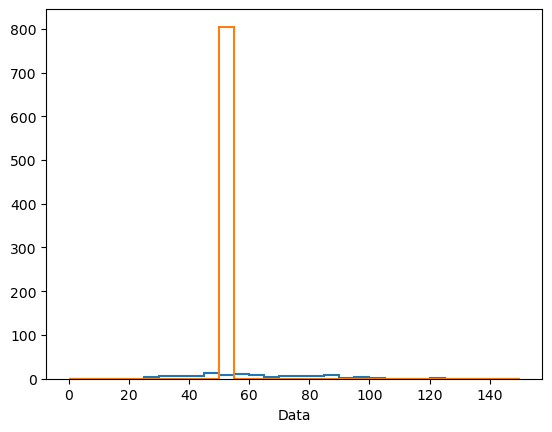

In [28]:
mt_results_local["Data"]["mass"].plot()
mt_results_local["DYJets"]["mass"].plot()
#mt_results_local["WJets"]["mass"].plot()
#mt_results_local["TT"]["mass"].plot()
#mt_results_local["VV"]["mass"].plot()

Data_h, Data_bins = mt_results_local["Data"]["mass"].to_numpy()

In [42]:
d = {}
bins = np.linspace(0,150,30)

QCDScaleFactor = 1.6996559936491136

d["Data_h"], d["Data_bins"] = mt_results_local["Data"]["mass"].to_numpy()
d["Data_SS_h"], d["Data_SS_bins"] = mt_results_local["Data"]["ss_mass"].to_numpy()
labels1 = ["DYJets", "WJets", "TT", "VV"]
for i in labels1:
    d[i + "_h"], d[i + "_bins"] =  mt_results_local[i]["mass"].to_numpy()
    d[i + "_SS_h"], d[i + "_SS_bins"] =  mt_results_local[i]["ss_mass"].to_numpy()

d["QCD_h"] = np.subtract(np.subtract(np.subtract(d["Data_SS_h"], d["DYJets_SS_h"], dtype=object, out=None), d["WJets_SS_h"], dtype=object, out=None), d["TT_SS_h"], dtype=object, out=None)
for i in range(d["QCD_h"].size):
    if d["QCD_h"][i] < 0.0:
        d["QCD_h"][i] = 0.0
    d["QCD_w"] = np.full(shape=d["QCD_h"].shape, fill_value=QCDScaleFactor, dtype=np.double)
    d["QCD_hist"] = (d["QCD_h"], d["Data_SS_bins"])


In [43]:
outFile = uproot.recreate("boostedHTT_mt_2018_local.input.root")
outFile["DYJets_met_1_13_TeV/data_obs"] = mt_results_local["Data"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/QCD"] = d["QCD_hist"]
outFile["DYJets_met_1_13TeV/WJets"] = mt_results_local["WJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/DYJets125"] = mt_results_local["DYJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/TT"] = mt_results_local["TT"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/VV"] = mt_results_local["VV"]["mass"].to_numpy()


In [33]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

In [16]:
PWD = os.getcwd()
print(f'Transferring contents of {PWD} to workers')
INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="4 GB",
    disk="2 GB",
    death_timeout = '60',
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "+SingularityImage": '"/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask:0.7.22-py3.10-g7cbcc"',
        "Requirements": "HasSingularityJobStart",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path}'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
dask_executor = processor.DaskExecutor(client=client, status=True)
print("Executor created")

client

Transferring contents of /afs/hep.wisc.edu/user/emettner/rootProjects/Radion-DiHiggs-4Tau/NanoRun to workers
Condor logs, output files, error files in /scratch/emettner
Executor created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:18677,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [17]:
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=dask_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 5000 and maxchunks None


In [18]:
print("Calling runner")
mt_results_dask = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Calling runner


OSError: XRootD error: [FATAL] TLS error
in file root://cmsxrootd.hep.wisc.edu//hdfs/store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_2.root

In [19]:
for dset,results, in mt_results_dask.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount'].value}")

NameError: name 'mt_results_dask' is not defined

In [ ]:
outFile = uproot.recreate("boostedHTT_mt_2018.input.root")


